In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler

from torchvision import transforms, datasets

from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils import class_weight

from PIL import Image
from torch.optim.lr_scheduler import StepLR
import random
import time
from tqdm import tqdm
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [26]:
seed = 42
torch.manual_seed(seed)           
random.seed(seed)                  
np.random.seed(seed)               
torch.cuda.manual_seed(seed)       
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False

# **TENSORBOARD SETUP**

In [27]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


**Note: change the name of your directory. For example, if your model's name is "Deit" then log_dir="runs/deit". *Do not change the main directory "runs"!***

In [28]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="runs/Xception") 

# **DATA LOADING & PREPROCESSING**

In [29]:
train_data_path = '/kaggle/input/train'
test_data_path = '/kaggle/input/test'

In [30]:
# Load dataset
train_dataset = datasets.ImageFolder(root=train_data_path)

# Print class-to-index mapping
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

# Get counts of each label
label_counts = Counter([sample[1] for sample in train_dataset.samples])

# Print counts for each label
print("Label Counts:")
for label, count in label_counts.items():
    class_name = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(label)]
    print(f"{class_name}: {count} images")


Class-to-Index Mapping: {'benign': 0, 'malignant': 1}
Label Counts:
benign: 1440 images
malignant: 1197 images


In [31]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Vertical flip
    transforms.RandomRotation(degrees=10),  # Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),  # Gaussian noise
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [32]:
train_dataset = datasets.ImageFolder(root=train_data_path , transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training Set Size: {len(train_dataset)} images")
print(f"Testing Set Size: {len(test_dataset)} images")

Training Set Size: 2637 images
Testing Set Size: 660 images


Training Label Distribution: {'benign': 1440, 'malignant': 1197}
Testing Label Distribution: {'benign': 360, 'malignant': 300}


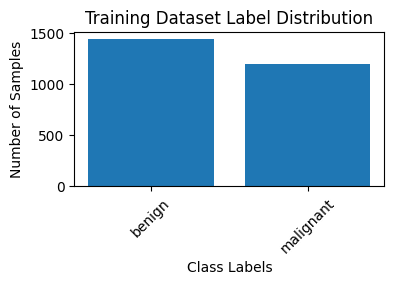

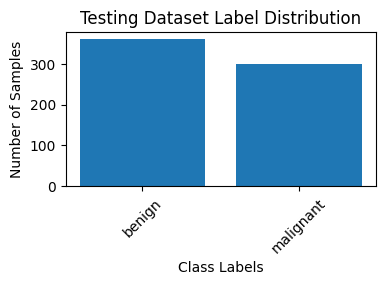

In [33]:
train_labels = [label for _, label in train_dataset.samples]
train_label_counts = Counter(train_labels)

test_labels = [label for _, label in test_dataset.samples]
test_label_counts = Counter(test_labels)

class_names = train_dataset.classes
train_label_names = {class_names[label]: count for label, count in train_label_counts.items()}
test_label_names = {class_names[label]: count for label, count in test_label_counts.items()}

# Visualize label distributions
print("Training Label Distribution:", train_label_names)
print("Testing Label Distribution:", test_label_names)

def plot_label_distribution(label_counts, title):
    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=(4, 2))
    plt.bar(labels, counts)
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_label_distribution(train_label_names, "Training Dataset Label Distribution")
plot_label_distribution(test_label_names, "Testing Dataset Label Distribution")

# **LOAD MODEL**

**Note: Load your model here**

In [34]:

from timm import create_model

# Load a pretrained Xception model
model = create_model('xception', pretrained=True)  # Loads the pretrained Xception model
num_features = model.fc.in_features  # Access the fully connected layer
model.fc = nn.Linear(num_features, 2)  # Modify for binary classification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)




/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [35]:
labels = [label for _, label in train_dataset.samples] 
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **TRAINING**

In [36]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss):
        if train_loss < self.best_loss - self.delta:
            self.best_loss = train_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.patience} epochs with no improvement.")
                self.early_stop = True

In [37]:
def plot_training_results(train_losses, train_accuracies, learning_rates, fps, gpu_usage):
    # Learning Rate
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid()
    plt.show()

    # Training Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # FPS
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(fps) + 1), fps, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Frames Per Second (FPS)")
    plt.title("Training Speed (FPS)")
    plt.grid()
    plt.show()

    # GPU Usage
    allocated, reserved = zip(*gpu_usage)
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(allocated)), allocated, label="GPU Allocated (GB)")
    plt.plot(range(len(reserved)), reserved, label="GPU Reserved (GB)")
    plt.xlabel("Batches")
    plt.ylabel("GPU Memory (GB)")
    plt.title("GPU Memory Usage")
    plt.legend()
    plt.grid()
    plt.show()

def write_training_results(train_losses, train_accuracies, learning_rates, fps, gpu_usage):
    # Learning Rate
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid()
    fig = plt.gcf()
    if writer:
        writer.add_figure("Learning Rate Schedule", fig)

    # Training Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()
    plt.grid()
    fig = plt.gcf()
    if writer:
        writer.add_figure("Training Accuracy", plt.gcf())

    # FPS
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(fps) + 1), fps, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Frames Per Second (FPS)")
    plt.title("Training Speed (FPS)")
    plt.grid()
    fig = plt.gcf()
    if writer:
        writer.add_figure("Training Speed (FPS)", fig)

    # GPU Usage
    allocated, reserved = zip(*gpu_usage)
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(allocated)), allocated, label="GPU Allocated (GB)")
    plt.plot(range(len(reserved)), reserved, label="GPU Reserved (GB)")
    plt.xlabel("Batches")
    plt.ylabel("GPU Memory (GB)")
    plt.title("GPU Memory Usage")
    plt.legend()
    plt.grid()
    fig = plt.gcf()
    if writer:
        writer.add_figure("GPU Memory Usage", fig)

In [38]:
def train_model(model, train_loader, optimizer, scheduler, criterion, device, patience=5, num_epochs=50):
    early_stopping = EarlyStopping(patience=patience)
    model.to(device)

    # Lists to track metrics
    train_losses, train_accuracies, learning_rates = [], [], []
    gpu_usage, fps = [], []

    for epoch in range(num_epochs):
        # Fetch and print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)  # Track learning rate
        writer.add_scalar("Learning Rate", current_lr, epoch)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}")

        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # GPU memory tracking
        start_time = time.time()
        for images, labels in tqdm(train_loader, desc="Training Batches"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Check for logits attribute (e.g., in DeiT models)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            # Compute loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Monitor GPU memory usage
        gpu_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # Convert to GB
        gpu_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)   
        gpu_usage.append((gpu_allocated, gpu_reserved))

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)  # Track training loss
        train_accuracies.append(epoch_acc)  # Track training accuracy

        # Log training loss and accuracy to TensorBoard
        writer.add_scalar("Loss/Train", epoch_loss, epoch)
        writer.add_scalar("Accuracy/Train", epoch_acc, epoch)

        # Measure FPS
        end_time = time.time()
        fps_epoch = len(train_loader.dataset) / (end_time - start_time)
        fps.append(fps_epoch)

        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%, FPS: {fps_epoch:.2f}")
        print(f"GPU Memory Allocated: {gpu_allocated:.2f} GB, GPU Memory Reserved: {gpu_reserved:.2f} GB")

        # Log FPS
        writer.add_scalar("Training/FPS", fps_epoch, epoch)

        # Step the LR scheduler
        scheduler.step(epoch_loss)

        # Early Stopping Check
        early_stopping(epoch_loss)
        if early_stopping.early_stop:
            print("Stopping early due to convergence.")
            break

    # Plot Results
    plot_training_results(train_losses, train_accuracies, learning_rates, fps, gpu_usage)
    write_training_results(train_losses, train_accuracies, learning_rates, fps, gpu_usage)


Epoch 1/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:40<00:00,  2.03it/s]


Training Loss: 0.3878, Training Accuracy: 82.03%, FPS: 64.48
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 2/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:42<00:00,  1.96it/s]


Training Loss: 0.2458, Training Accuracy: 89.31%, FPS: 62.28
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 3/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:42<00:00,  1.94it/s]


Training Loss: 0.2060, Training Accuracy: 91.20%, FPS: 61.73
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 4/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:42<00:00,  1.94it/s]


Training Loss: 0.1696, Training Accuracy: 92.42%, FPS: 61.47
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 5/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.1340, Training Accuracy: 95.11%, FPS: 60.14
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 6/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.1199, Training Accuracy: 95.15%, FPS: 58.76
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 7/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.90it/s]


Training Loss: 0.0946, Training Accuracy: 96.44%, FPS: 60.32
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 8/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.0837, Training Accuracy: 97.12%, FPS: 59.93
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 9/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.0609, Training Accuracy: 97.76%, FPS: 60.17
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 10/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.88it/s]


Training Loss: 0.0667, Training Accuracy: 97.27%, FPS: 59.77
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 11/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.0413, Training Accuracy: 98.82%, FPS: 60.14
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 12/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.0489, Training Accuracy: 98.33%, FPS: 60.15
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 13/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.88it/s]


Training Loss: 0.0383, Training Accuracy: 98.67%, FPS: 59.86
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 14/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s]


Training Loss: 0.0343, Training Accuracy: 98.79%, FPS: 59.92
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 15/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.87it/s]


Training Loss: 0.0292, Training Accuracy: 98.86%, FPS: 59.31
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 16/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s]


Training Loss: 0.0392, Training Accuracy: 99.05%, FPS: 57.08
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 17/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0312, Training Accuracy: 98.79%, FPS: 58.84
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 18/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.87it/s]


Training Loss: 0.0285, Training Accuracy: 99.01%, FPS: 59.51
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 19/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0332, Training Accuracy: 98.94%, FPS: 58.85
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 20/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.86it/s]


Training Loss: 0.0330, Training Accuracy: 98.79%, FPS: 58.93
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 21/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0306, Training Accuracy: 99.05%, FPS: 58.92
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 22/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s]


Training Loss: 0.0214, Training Accuracy: 99.28%, FPS: 57.42
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 23/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0222, Training Accuracy: 98.94%, FPS: 58.82
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 24/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.86it/s]


Training Loss: 0.0301, Training Accuracy: 98.90%, FPS: 59.07
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 25/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.88it/s]


Training Loss: 0.0172, Training Accuracy: 99.66%, FPS: 59.71
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 26/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.80it/s]


Training Loss: 0.0110, Training Accuracy: 99.58%, FPS: 57.34
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 27/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.83it/s]


Training Loss: 0.0181, Training Accuracy: 99.62%, FPS: 58.24
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 28/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0423, Training Accuracy: 98.67%, FPS: 58.77
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 29/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s]


Training Loss: 0.0240, Training Accuracy: 99.20%, FPS: 57.65
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 30/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.84it/s]


Training Loss: 0.0085, Training Accuracy: 99.77%, FPS: 58.34
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 31/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.83it/s]


Training Loss: 0.0078, Training Accuracy: 99.73%, FPS: 58.28
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 32/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s]


Training Loss: 0.0108, Training Accuracy: 99.62%, FPS: 57.76
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 33/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.84it/s]


Training Loss: 0.0115, Training Accuracy: 99.58%, FPS: 58.36
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 34/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s]


Training Loss: 0.0134, Training Accuracy: 99.39%, FPS: 57.71
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 35/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.85it/s]


Training Loss: 0.0177, Training Accuracy: 99.47%, FPS: 58.78
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB

Epoch 36/50, Learning Rate: 0.000100


Training Batches: 100%|██████████| 83/83 [00:44<00:00,  1.87it/s]


Training Loss: 0.0162, Training Accuracy: 99.32%, FPS: 59.44
GPU Memory Allocated: 0.50 GB, GPU Memory Reserved: 6.95 GB
Early stopping triggered after 5 epochs with no improvement.
Stopping early due to convergence.


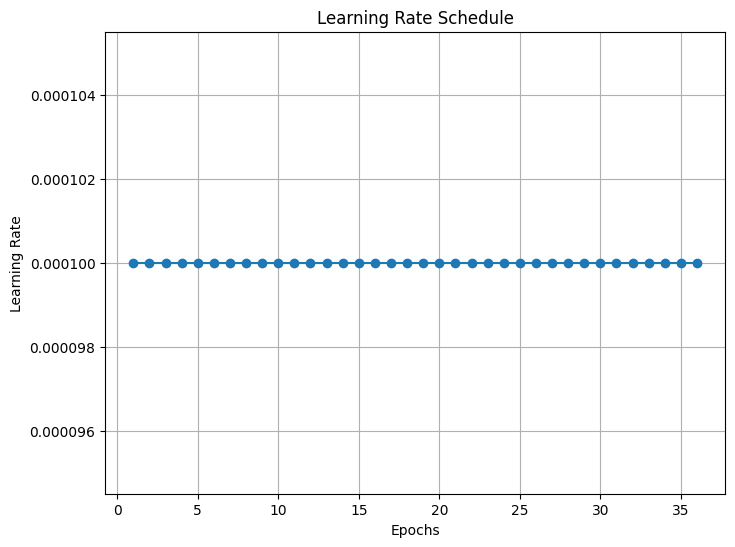

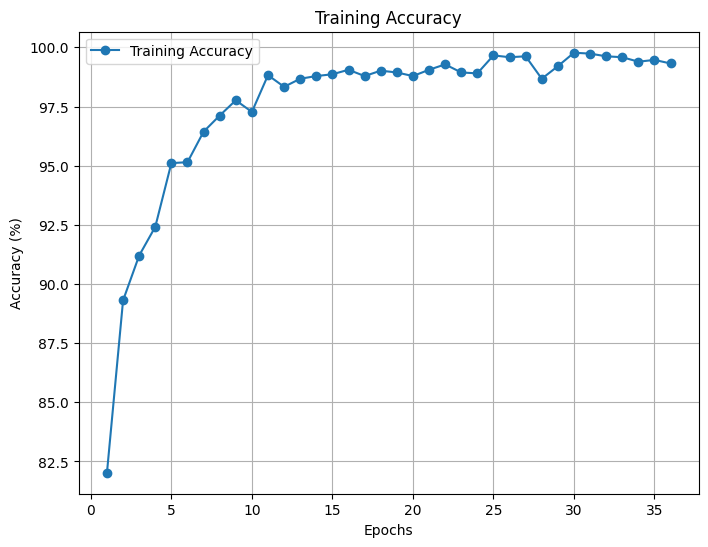

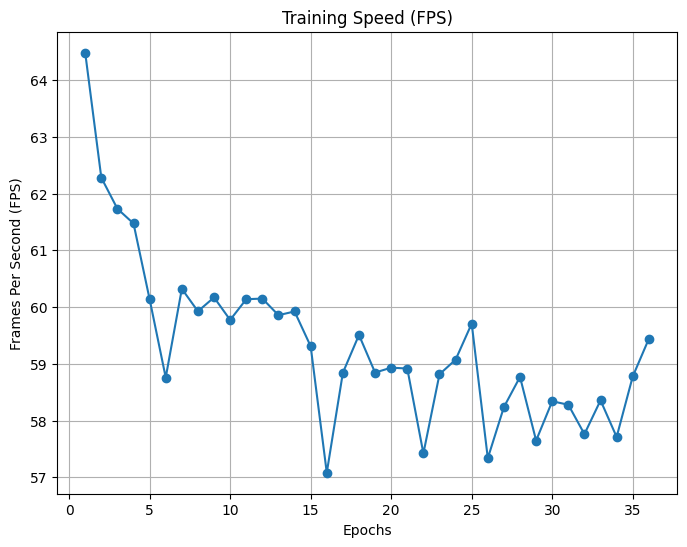

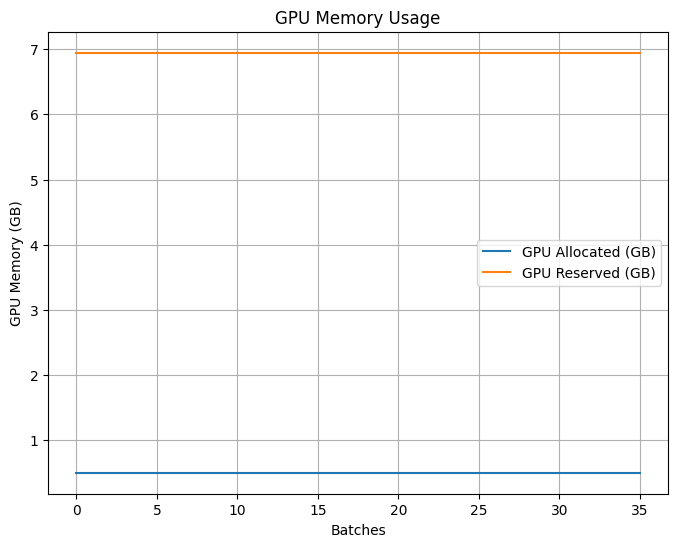

In [39]:
train_model(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    patience=5,  
    num_epochs=50
)

# **EVALUATION**

In [40]:
def evaluate_model_with_metrics(model, loader, binary_classification=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            
            # Get model outputs
            outputs = model(images)
            
            # For DeiT models, extract logits
            if hasattr(outputs, 'logits'):  
                outputs = outputs.logits
            
            # Get predicted classes
            _, predicted = outputs.max(1)

            # Accumulate metrics
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Probabilities for ROC AUC
            if binary_classification:
                probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probabilities)

    # Accuracy
    accuracy = 100. * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    writer.add_scalar("Evaluation/Accuracy", accuracy)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels), cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    fig = plt.gcf()
    if writer:
        writer.add_figure("Evaluation/Confusion Matrix", fig)

    # Precision, Recall, F1-Score
    precision = precision_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    recall = recall_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    f1 = f1_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    writer.add_scalar("Evaluation/Precision", precision)
    writer.add_scalar("Evaluation/Recall", recall)
    writer.add_scalar("Evaluation/F1-Score", f1)

    # AUC-ROC and ROC Curve (for binary classification)
    if binary_classification:
        all_probs = np.array(all_probs)
        if len(np.unique(all_labels)) == 2: 
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            auc_score = auc(fpr, tpr)
            print(f"AUC-ROC: {auc_score:.4f}")

            # Plot ROC Curve
            plt.figure()
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.grid()
            fig = plt.gcf()
            if writer:
                writer.add_figure("Evaluation/ROC Curve", fig)
        else:
            print("AUC-ROC is not supported for multi-class tasks without modification.")

In [41]:
evaluate_model_with_metrics(model, test_loader, binary_classification=True)

Accuracy on test set: 91.67%
Confusion Matrix:
 [[342  18]
 [ 37 263]]
Precision: 0.9359
Recall: 0.8767
F1-Score: 0.9053
AUC-ROC: 0.9777


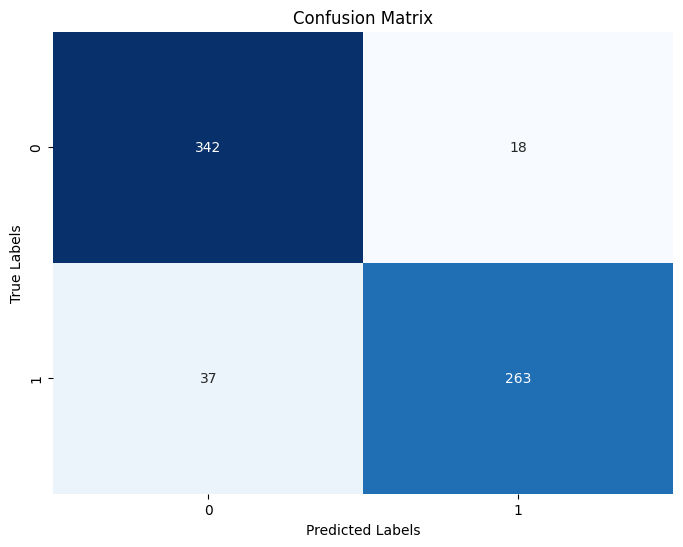

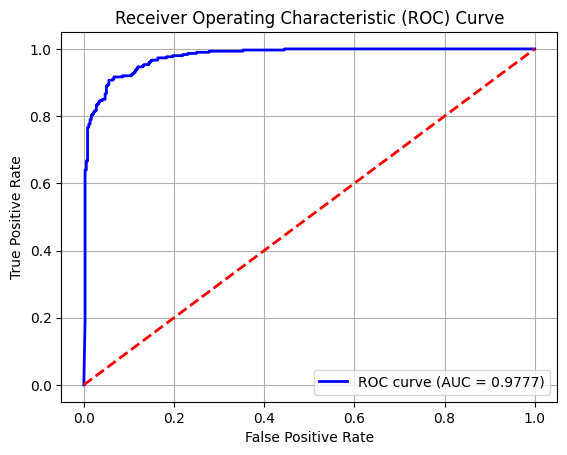

In [42]:
def plot_confusion_roc(model, loader, binary_classification=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)

            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # For ROC AUC
            if binary_classification:
                probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probabilities)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels), cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve (for binary classification)
    if binary_classification:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        auc_score = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

plot_confusion_roc(model, test_loader, binary_classification=True)

# **COMPUTATIONAL EFFICIENCY METRIC**

In [43]:
pip install fvcore

Note: you may need to restart the kernel to use updated packages.


In [44]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
import time
from prettytable import PrettyTable
from fvcore.nn import FlopCountAnalysis, parameter_count_table


In [45]:
image, label = train_dataset[0]  # Use the first image from the dataset
image = image.unsqueeze(0).to(device)
input_tensor = image
batch_size = 1

flops = FlopCountAnalysis(model, image)
total_flops = flops.total() / 1e9  # Convert to GFLOPs
params_table = parameter_count_table(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Inference Time
start_time = time.time()
for _ in range(10):  # Run for 10 iterations
    with torch.no_grad():
        model(input_tensor)
end_time = time.time()
batch_inference_time = (end_time - start_time) / 10
per_image_inference_time = batch_inference_time / batch_size

# GPU Memory Usage
if device == 'cuda':
    gpu_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)
    gpu_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)
else:
    gpu_allocated = gpu_reserved = 0.0

# Throughput (FPS)
throughput = batch_size / batch_inference_time

from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["FLOPs (GFLOPs)", f"{total_flops:.2f}"])
table.add_row(["Total Parameters", f"{total_params:,}"])
table.add_row(["Trainable Parameters", f"{trainable_params:,}"])
table.add_row(["Inference Time (Batch)", f"{batch_inference_time:.4f} seconds"])
table.add_row(["Inference Time (Per Image)", f"{per_image_inference_time:.4f} seconds"])
table.add_row(["Throughput (FPS)", f"{throughput:.2f} images/second"])
table.add_row(["GPU Memory Allocated", f"{gpu_allocated:.2f} GB"])
table.add_row(["GPU Memory Reserved", f"{gpu_reserved:.2f} GB"])

print(table)

# Log computational metrics to TensorBoard
writer.add_scalar("Efficiency/FLOPs (GFLOPs)", total_flops)
writer.add_scalar("Efficiency/Total Parameters", total_params)
writer.add_scalar("Efficiency/Inference Time (ms)", per_image_inference_time * 1000)
writer.add_scalar("Efficiency/Throughput (FPS)", throughput)


+----------------------------+----------------------+
|           Metric           |        Value         |
+----------------------------+----------------------+
|       FLOPs (GFLOPs)       |         4.57         |
|      Total Parameters      |      20,811,050      |
|    Trainable Parameters    |      20,811,050      |
|   Inference Time (Batch)   |    0.0058 seconds    |
| Inference Time (Per Image) |    0.0058 seconds    |
|      Throughput (FPS)      | 171.17 images/second |
|    GPU Memory Allocated    |       0.33 GB        |
|    GPU Memory Reserved     |       6.95 GB        |
+----------------------------+----------------------+


In [46]:
writer.close()

# **SAVE MODEL & LOGS**

In [47]:
path_50epochs = '/kaggle/working/model.pth'

torch.save(model.state_dict(), path_50epochs)

print("Models saved successfully to /kaggle/working/")

Models saved successfully to /kaggle/working/


In [48]:
!tar -czf tensorboard_logs.tar.gz runs